In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import sys
import os

#optional for nicer plots
import seaborn
seaborn.set(style='ticks',font_scale=1.5)

In [16]:
sys.path.append("/Users/yves/Desktop/retreat_data_dir/code/")
from mecll.of import get_spatial_firing_rate_maps,get_split_half_correlations,filter_gaussian

#  Load data

In [17]:
#These are the times (in units of camera frames) at which spikes occurred
root_dir = '/Users/yves/Desktop/retreat_data_dir/data/2021-07-31_39951_ks25/'
spkT = np.load(os.path.join(root_dir,'spkT_OF.npy'))


#This array is the same shape as spkT but shows which cluster each of the spikes in spkT belongs to
spkC = np.load(os.path.join(root_dir,'spkC_OF.npy'))


#n_timepoints x 2 array containing the x and y position of the animal at each camera frame
position = np.load(os.path.join(root_dir,'OF_positions.npy'))

#not all cluster in spkC correspond to single units. Single units is an array of the clusters that are single units
single_units = np.load(os.path.join(root_dir,'single_units.npy'))

# Calculate and plot speed over time

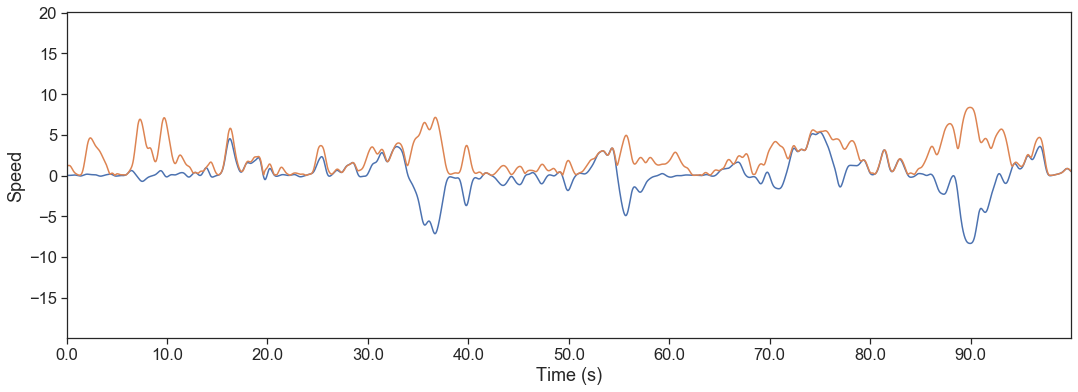

In [18]:

plt.figure(figsize=(18,6))

delta_p = np.diff(position,axis=0)
delta_p[np.logical_not(np.isfinite(delta_p[:,0])),:] = 0  #set nans to 0

delta_p = ndi.gaussian_filter1d(delta_p,8,axis=0)  #smooth

speed = np.concatenate([[0],np.sqrt(np.sum(delta_p**2,axis=1))])
plt.plot(delta_p[:,0])
plt.plot(speed)
plt.ylabel("Speed")
plt.xlabel("Time (s)")
#plt.plot(ndi.gaussian_filter1d(delta_p[:,0],7))

plt.xlim(0,3000)
plt.xticks(np.arange(0,3000,300),np.arange(0,3000,300)/30.)
#plt.ylim(-10,10)
print()

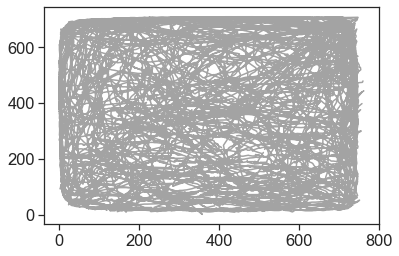

In [19]:
#occupancy_map
plt.plot(position[speed>2,0],position[speed>2,1],color='k',alpha=.4)


In [20]:

ccs = get_split_half_correlations(spkC,spkT,single_units,position,speed,SPEED_THRESH=2,)

processing unit:58/679

/Users/yves/Desktop/retreat_data_dir/code/mecll/of.py:78: RuntimeWarning: invalid value encountered in true_divide
  norm_firing = spike_poss/occupancy_map1
/Users/yves/Desktop/retreat_data_dir/code/mecll/of.py:84: RuntimeWarning: invalid value encountered in true_divide
  norm_firing = spike_poss/occupancy_map2


processing unit:679/679

Text(0.5, 0, 'Correlation coeffient between firing rate maps \ncomputed from data halves')

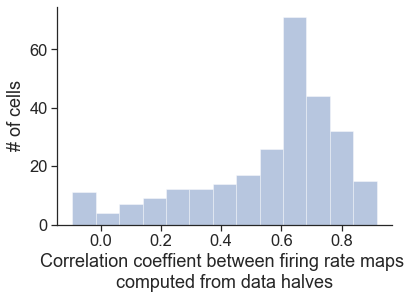

In [21]:
seaborn.distplot(ccs[np.isfinite(ccs)],kde=0)
seaborn.despine()
plt.ylabel("# of cells")
plt.xlabel("Correlation coeffient between firing rate maps \ncomputed from data halves")

# get spatial maps 

In [25]:
all_resp_arr = get_spatial_firing_rate_maps(position,speed,spkC,spkT,single_units,
                                            SMOOTHING_FACTOR=2,SPEED_THRESH=1)

 processing unit: 9/274

/Users/yves/Desktop/retreat_data_dir/code/mecll/of.py:144: RuntimeWarning: invalid value encountered in true_divide
  norm_firing = spike_poss/occupancy_map  #calculate spikes_in_bin/time_in_bin


 processing unit: 273/274

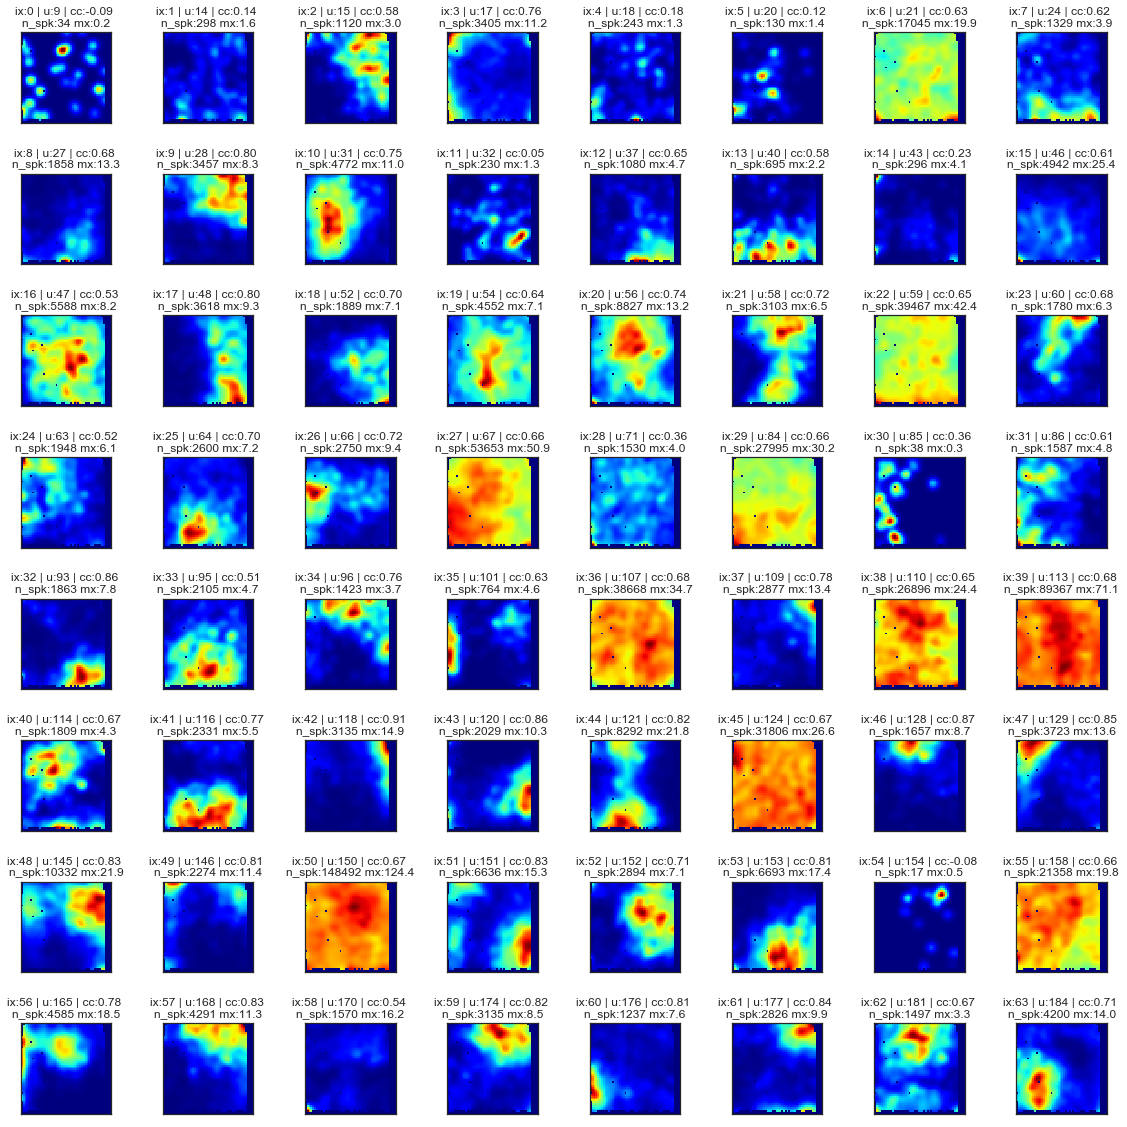

In [30]:

#plot spatial responses of 64 cells at a time. Change n64 to other ints to view the next 'n64' ones
plt.figure(figsize=(16,16))
kk = 1

n64 = 0
for ix in range(n64*64,(n64+1)*64):
    try:
        unit_nr,resp_map,tot,mx = all_resp_arr[ix]
        plt.subplot(8,8,kk)
        #ix is cell unit index, u is which number in spkC it is, cc is spatial stability from get_split_half_correlations()
        #nspk is number of spikes fired during open field and mx is peak firing rate (in Hz) in the spatial rate-map
        plt.title('ix:{} | u:{} | cc:{:.2f} \nn_spk:{} mx:{}'.format(ix,unit_nr,ccs[ix],tot,np.round(mx,decimals=1)),fontsize=12)

        plt.imshow(resp_map,cmap='jet',interpolation='None')
        plt.xticks([])
        plt.yticks([])

        kk += 1
    except (ValueError,IndexError):
        break
plt.tight_layout()